<a href="https://colab.research.google.com/github/havryliukbohdana/Lab-1/blob/main/Lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np
import pandas as pd
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import os

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [57]:
# Трансформації для тренувального набору (з аугментаціями)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Трансформації для валідаційного/тестового набору
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [58]:
# Завантажуємо повний датасет
full_dataset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', download=True)

In [59]:
# Фільтруємо датасет: тільки коти та собаки
cat_indices = [i for i, path in enumerate(full_dataset._images) if path.name[0].isupper()]
dog_indices = [i for i, path in enumerate(full_dataset._images) if path.name[0].islower()]

# Створюємо нові мітки: 0 для котів, 1 для собак
cat_labels = [0] * len(cat_indices)
dog_labels = [1] * len(dog_indices)

# Об'єднуємо індекси та мітки
all_indices = cat_indices + dog_indices
all_labels = cat_labels + dog_labels

# Створюємо кастомний клас датасету, щоб перевизначити мітки
class CustomPetDataset(torch.utils.data.Dataset):
    def __init__(self, subset, labels, transform=None):
        self.subset = subset
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        image, _ = self.subset[index] # Оригінальну мітку ігноруємо
        label = self.labels[index]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.subset)

In [60]:
# Розділяємо дані на тренувальну та валідаційну вибірки
# Спочатку створюємо підмножину з потрібними індексами
filtered_subset = Subset(full_dataset, all_indices)

# Розділяємо на тренувальну та валідаційну (80/20)
train_size = int(0.8 * len(filtered_subset))
val_size = len(filtered_subset) - train_size
generator = torch.Generator().manual_seed(42) # для відтворюваності
train_subset_indices, val_subset_indices = random_split(range(len(filtered_subset)), [train_size, val_size], generator=generator)

# Отримуємо відповідні мітки для кожного набору
train_labels = [all_labels[i] for i in train_subset_indices.indices]
val_labels = [all_labels[i] for i in val_subset_indices.indices]

# Створюємо фінальні датасети з відповідними трансформаціями
train_dataset = CustomPetDataset(Subset(filtered_subset, train_subset_indices.indices), train_labels, transform=train_transforms)
val_dataset = CustomPetDataset(Subset(filtered_subset, val_subset_indices.indices), val_labels, transform=val_transforms)

In [61]:
BATCH_SIZE = 128
NUM_WORKERS = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Кількість зображень у тренувальному наборі: {len(train_dataset)}")
print(f"Кількість зображень у валідаційному наборі: {len(val_dataset)}")
print(f"Класи: {np.unique(all_labels)}")

Кількість зображень у тренувальному наборі: 2944
Кількість зображень у валідаційному наборі: 736
Класи: [0 1]


In [62]:
def get_mobilenet_v2_tl(num_classes=2):
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

mobilenet_v2_model = get_mobilenet_v2_tl()

In [63]:
def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, labels in tqdm(loader, desc="Training"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_time = time.time() - start_time
    return epoch_loss, epoch_time

In [64]:
def validate_model(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, accuracy, macro_f1, all_labels, all_preds

In [65]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Loss History')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Accuracy History')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    plt.show()

In [66]:
def plot_confusion_matrix(labels, preds, class_names):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [67]:
# Налаштування для MobileNetV2
model_mobilenet = get_mobilenet_v2_tl().to(device)
optimizer_mobilenet = optim.Adam(model_mobilenet.classifier[1].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scaler_mobilenet = GradScaler()
num_epochs = 10

history_mobilenet = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'epoch_time': []}

# Рання зупинка
patience_mobilenet = 3
counter_mobilenet = 0
best_val_loss_mobilenet = float('inf')
best_model_path_mobilenet = 'mobilenet_v2_best.pth'

print("\nStarting FAST training for MobileNetV2 (TL) with Early Stopping")
for epoch in range(num_epochs):
    train_loss, epoch_time = train_one_epoch(model_mobilenet, train_loader, optimizer_mobilenet, criterion, scaler_mobilenet)
    val_loss, val_acc, val_f1, _, _ = validate_model(model_mobilenet, val_loader, criterion)

    history_mobilenet['train_loss'].append(train_loss)
    history_mobilenet['val_loss'].append(val_loss)
    history_mobilenet['val_acc'].append(val_acc)
    history_mobilenet['val_f1'].append(val_f1)
    history_mobilenet['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss_mobilenet:
        best_val_loss_mobilenet = val_loss
        torch.save(model_mobilenet.state_dict(), best_model_path_mobilenet)
        print(f"Val loss improved to {best_val_loss_mobilenet:.4f}, saving model.")
        counter_mobilenet = 0
    else:
        counter_mobilenet += 1
        if counter_mobilenet >= patience_mobilenet:
            print("Early stopping triggered")
            break

print(f"\nTraining finished. Loading best model from {best_model_path_mobilenet}")
model_mobilenet.load_state_dict(torch.load(best_model_path_mobilenet))


Starting FAST training for MobileNetV2 (TL) with Early Stopping


/tmp/ipython-input-1196043844.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_mobilenet = GradScaler()


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/10 | Time: 20.31s | Val Loss: 0.1772 | Val Acc: 0.9497
Val loss improved to 0.1772, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/10 | Time: 18.43s | Val Loss: 0.1241 | Val Acc: 0.9592
Val loss improved to 0.1241, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/10 | Time: 19.40s | Val Loss: 0.1062 | Val Acc: 0.9620
Val loss improved to 0.1062, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/10 | Time: 19.51s | Val Loss: 0.0974 | Val Acc: 0.9606
Val loss improved to 0.0974, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/10 | Time: 18.51s | Val Loss: 0.0930 | Val Acc: 0.9620
Val loss improved to 0.0930, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/10 | Time: 18.47s | Val Loss: 0.0878 | Val Acc: 0.9660
Val loss improved to 0.0878, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/10 | Time: 19.12s | Val Loss: 0.0875 | Val Acc: 0.9620
Val loss improved to 0.0875, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/10 | Time: 19.64s | Val Loss: 0.0892 | Val Acc: 0.9688


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/10 | Time: 19.04s | Val Loss: 0.0810 | Val Acc: 0.9660
Val loss improved to 0.0810, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/10 | Time: 18.55s | Val Loss: 0.0795 | Val Acc: 0.9660
Val loss improved to 0.0795, saving model.

Training finished. Loading best model from mobilenet_v2_best.pth


<All keys matched successfully>

Evaluating MobileNetV2


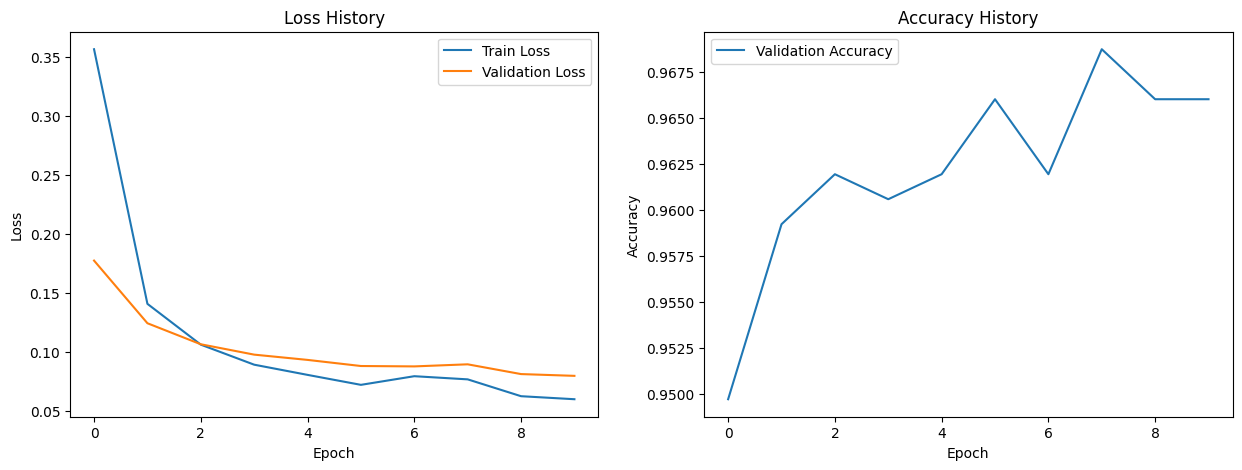

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

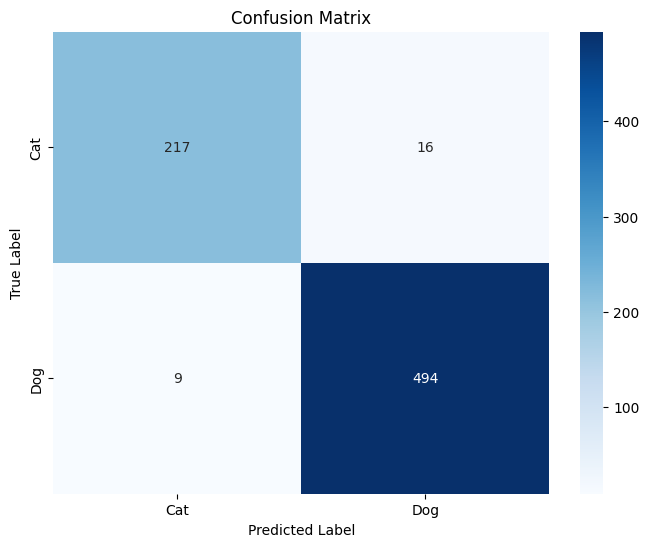

In [68]:
print("Evaluating MobileNetV2")
plot_training_history(history_mobilenet)

_, _, _, val_labels_fast, val_preds_fast = validate_model(model_mobilenet, val_loader, criterion)
plot_confusion_matrix(val_labels_fast, val_preds_fast, class_names=['Cat', 'Dog'])

In [69]:
def get_efficientnet_b0_tl(num_classes=2):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)

    for param in model.parameters():
        param.requires_grad = False

    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)

    return model

In [70]:
# Налаштування для EfficientNet-B0
model_effnet = get_efficientnet_b0_tl().to(device)
optimizer_effnet = optim.Adam(model_effnet.classifier[1].parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scaler_effnet = GradScaler()
num_epochs = 10

history_effnet = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'epoch_time': []}

# Рання зупинка
patience_effnet = 3
counter_effnet = 0
best_val_loss_effnet = float('inf')
best_model_path_effnet = 'efficientnet_b0_best.pth'

print("\nStarting FAST training for EfficientNet-B0 (TL) with Early Stopping")
for epoch in range(num_epochs):
    train_loss, epoch_time = train_one_epoch(model_effnet, train_loader, optimizer_effnet, criterion, scaler_effnet)
    val_loss, val_acc, val_f1, _, _ = validate_model(model_effnet, val_loader, criterion)

    history_effnet['train_loss'].append(train_loss)
    history_effnet['val_loss'].append(val_loss)
    history_effnet['val_acc'].append(val_acc)
    history_effnet['val_f1'].append(val_f1)
    history_effnet['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss_effnet:
        best_val_loss_effnet = val_loss
        torch.save(model_effnet.state_dict(), best_model_path_effnet)
        print(f"Val loss improved to {best_val_loss_effnet:.4f}, saving model.")
        counter_effnet = 0
    else:
        counter_effnet += 1
        if counter_effnet >= patience_effnet:
            print("Early stopping triggered")
            break

print(f"\nTraining finished. Loading best model from {best_model_path_effnet}")
model_effnet.load_state_dict(torch.load(best_model_path_effnet))


Starting FAST training for EfficientNet-B0 (TL) with Early Stopping


/tmp/ipython-input-1410063391.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_effnet = GradScaler()


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/10 | Time: 19.73s | Val Loss: 0.2970 | Val Acc: 0.9389
Val loss improved to 0.2970, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/10 | Time: 19.22s | Val Loss: 0.2198 | Val Acc: 0.9497
Val loss improved to 0.2198, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/10 | Time: 18.69s | Val Loss: 0.1811 | Val Acc: 0.9565
Val loss improved to 0.1811, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/10 | Time: 18.61s | Val Loss: 0.1591 | Val Acc: 0.9579
Val loss improved to 0.1591, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/10 | Time: 19.97s | Val Loss: 0.1452 | Val Acc: 0.9633
Val loss improved to 0.1452, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/10 | Time: 20.10s | Val Loss: 0.1333 | Val Acc: 0.9606
Val loss improved to 0.1333, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/10 | Time: 19.85s | Val Loss: 0.1269 | Val Acc: 0.9620
Val loss improved to 0.1269, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/10 | Time: 18.84s | Val Loss: 0.1229 | Val Acc: 0.9647
Val loss improved to 0.1229, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/10 | Time: 18.52s | Val Loss: 0.1135 | Val Acc: 0.9674
Val loss improved to 0.1135, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/10 | Time: 18.94s | Val Loss: 0.1104 | Val Acc: 0.9647
Val loss improved to 0.1104, saving model.

Training finished. Loading best model from efficientnet_b0_best.pth


<All keys matched successfully>

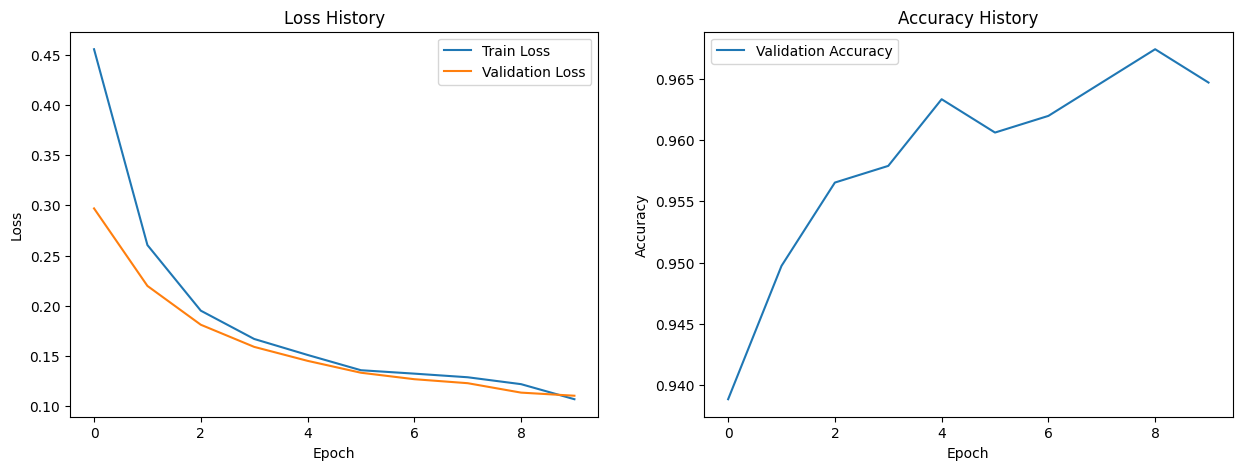

Validation:   0%|          | 0/6 [00:00<?, ?it/s]

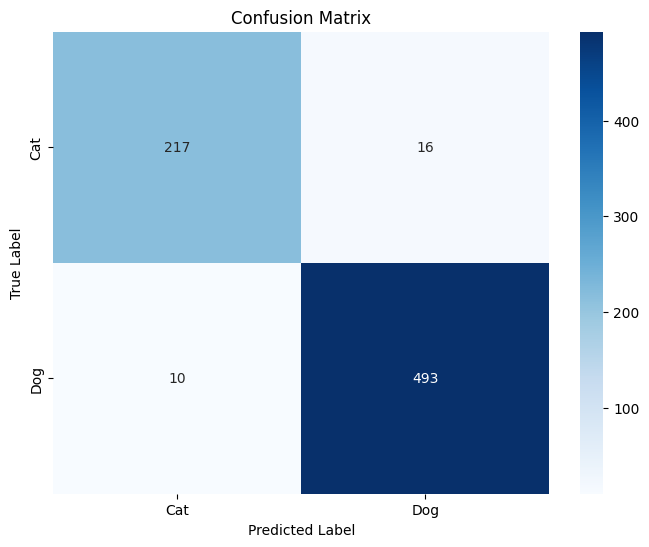

In [71]:
# Оцінка та візуалізація для EfficientNet-B0
plot_training_history(history_effnet)

# Запускаємо валідацію на найкращій моделі, щоб отримати фінальні прогнози
_, _, _, val_labels_effnet, val_preds_effnet = validate_model(model_effnet, val_loader, criterion)
plot_confusion_matrix(val_labels_effnet, val_preds_effnet, class_names=['Cat', 'Dog'])

In [72]:
!pip install torchinfo

In [73]:
from torchinfo import summary

In [74]:
# Для MobileNetV2
summary(model_mobilenet, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         (64)
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         (896)
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential

In [75]:
# Для EfficientNet-B0
summary(model_effnet, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         (64)
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         (1,448)
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           (6,004)
│    │    └─MBConv: 3-6                      

In [76]:
def measure_latency(model, device_str):
    model.to(device_str).eval()
    dummy_input = torch.randn(1, 3, 224, 224).to(device_str)

    for _ in range(10):
        _ = model(dummy_input)

    # Вимірювання
    times = []
    with torch.no_grad():
        for _ in range(100):
            if device_str == 'cuda': torch.cuda.synchronize()
            start_time = time.time()
            _ = model(dummy_input)
            if device_str == 'cuda': torch.cuda.synchronize()
            end_time = time.time()
            times.append((end_time - start_time) * 1000) # у мілісекундах

    return np.mean(times)

In [77]:
# Вимірюємо для MobileNetV2
latency_gpu_mobilenet = measure_latency(model_mobilenet, 'cuda')
latency_cpu_mobilenet = measure_latency(model_mobilenet, 'cpu')
print(f"MobileNetV2 Latency | GPU: {latency_gpu_mobilenet:.2f} ms | CPU: {latency_cpu_mobilenet:.2f} ms")

MobileNetV2 Latency | GPU: 10.60 ms | CPU: 47.41 ms


In [78]:
# Вимірюємо для EfficientNet-B0
latency_gpu_effnet = measure_latency(model_effnet, 'cuda')
latency_cpu_effnet = measure_latency(model_effnet, 'cpu')
print(f"EfficientNet-B0 Latency | GPU: {latency_gpu_effnet:.2f} ms | CPU: {latency_cpu_effnet:.2f} ms")

EfficientNet-B0 Latency | GPU: 19.87 ms | CPU: 37.32 ms


In [79]:
def get_efficientnet_b0_from_scratch(num_classes=2):
    model = models.efficientnet_b0(weights=None, num_classes=num_classes)
    return model

In [80]:
# --- Налаштування для EfficientNet-B0 (З НУЛЯ) ---
model_effnet_scratch = get_efficientnet_b0_from_scratch().to(device)

optimizer_effnet_scratch = optim.Adam(model_effnet_scratch.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scaler_effnet_scratch = GradScaler()
num_epochs = 30

history_effnet_scratch = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'epoch_time': []}

# --- Рання зупинка ---
patience_scratch = 7
counter_scratch = 0
best_val_loss_scratch = float('inf')
best_model_path_scratch = 'efficientnet_b0_scratch_best.pth'

print("\nStarting training for EfficientNet-B0 (FROM SCRATCH) with Early Stopping")
for epoch in range(num_epochs):
    train_loss, epoch_time = train_one_epoch(model_effnet_scratch, train_loader, optimizer_effnet_scratch, criterion, scaler_effnet_scratch)
    val_loss, val_acc, val_f1, _, _ = validate_model(model_effnet_scratch, val_loader, criterion)

    history_effnet_scratch['train_loss'].append(train_loss)
    history_effnet_scratch['val_loss'].append(val_loss)
    history_effnet_scratch['val_acc'].append(val_acc)
    history_effnet_scratch['val_f1'].append(val_f1)
    history_effnet_scratch['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_loss < best_val_loss_scratch:
        best_val_loss_scratch = val_loss
        torch.save(model_effnet_scratch.state_dict(), best_model_path_scratch)
        print(f"Val loss improved to {best_val_loss_scratch:.4f}, saving model.")
        counter_scratch = 0
    else:
        counter_scratch += 1
        if counter_scratch >= patience_scratch:
            print("Early stopping triggered!")
            break

print(f"\nTraining finished. Loading best model from {best_model_path_scratch}")
model_effnet_scratch.load_state_dict(torch.load(best_model_path_scratch))


Starting training for EfficientNet-B0 (FROM SCRATCH) with Early Stopping


/tmp/ipython-input-69817137.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_effnet_scratch = GradScaler()


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/30 | Time: 21.71s | Val Loss: 0.7391 | Val Acc: 0.6834
Val loss improved to 0.7391, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/30 | Time: 21.25s | Val Loss: 0.6249 | Val Acc: 0.6834
Val loss improved to 0.6249, saving model.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/30 | Time: 21.21s | Val Loss: 0.9561 | Val Acc: 0.3166


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/30 | Time: 21.11s | Val Loss: 0.9819 | Val Acc: 0.6821


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/30 | Time: 21.44s | Val Loss: 1.8766 | Val Acc: 0.6753


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/30 | Time: 21.02s | Val Loss: 0.6591 | Val Acc: 0.6726


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/30 | Time: 21.23s | Val Loss: 0.8767 | Val Acc: 0.6427


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/30 | Time: 20.83s | Val Loss: 0.9932 | Val Acc: 0.6698


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/30 | Time: 20.48s | Val Loss: 0.6539 | Val Acc: 0.6671
Early stopping triggered!

Training finished. Loading best model from efficientnet_b0_scratch_best.pth


<All keys matched successfully>

EfficientNet-B0 (З нуля, з аугментаціями)


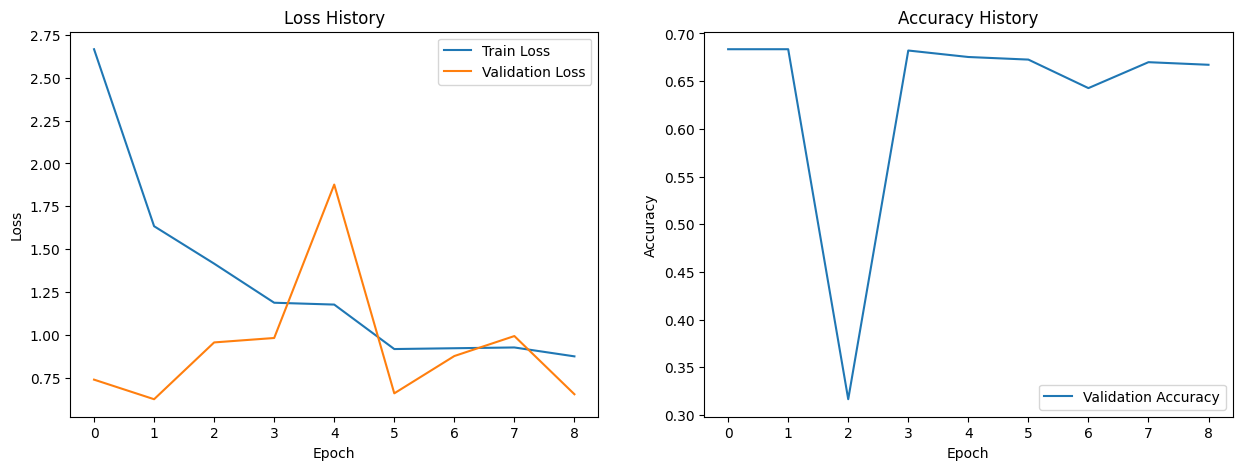

In [101]:
print("EfficientNet-B0 (З нуля, з аугментаціями)")
plot_training_history(history_effnet_scratch)

In [82]:
summary(model_effnet_scratch, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [1, 2]                    --
├─Sequential: 1-1                                       [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                        [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                                 [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         64
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         --
│    └─Sequential: 2-2                                  [1, 16, 112, 112]         --
│    │    └─MBConv: 3-4                                 [1, 16, 112, 112]         1,448
│    └─Sequential: 2-3                                  [1, 24, 56, 56]           --
│    │    └─MBConv: 3-5                                 [1, 24, 56, 56]           6,004
│    │    └─MBConv: 3-6                              

In [83]:
# Вимірюємо для EfficientNet-B0 (Scratch)
latency_gpu_effnet_scratch = measure_latency(model_effnet_scratch, 'cuda')
latency_cpu_effnet_scratch = measure_latency(model_effnet_scratch, 'cpu')
print(f"EfficientNet-B0 (Scratch) Latency | GPU: {latency_gpu_effnet_scratch:.2f} ms | CPU: {latency_cpu_effnet_scratch:.2f} ms")

EfficientNet-B0 (Scratch) Latency | GPU: 8.80 ms | CPU: 37.73 ms


In [84]:
train_transforms_no_aug = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset_no_aug = CustomPetDataset(
    Subset(filtered_subset, train_subset_indices.indices),
    train_labels,
    transform=train_transforms_no_aug
)

train_loader_no_aug = DataLoader(
    train_dataset_no_aug,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

In [85]:
# Налаштування для MobileNetV2 (TL) БЕЗ АУГМЕНТАЦІЙ
model_no_aug = get_mobilenet_v2_tl().to(device)
optimizer_no_aug = optim.Adam(model_no_aug.classifier[1].parameters(), lr=0.001)
scaler_no_aug = GradScaler()
num_epochs = 15
history_no_aug = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'epoch_time': []}
patience_no_aug = 3
counter_no_aug = 0
best_val_loss_no_aug = float('inf')

best_model_path_no_aug = 'mobilenet_v2_no_aug_best.pth'

print("\nStarting training for MobileNetV2 (TL) WITHOUT Augmentations")
for epoch in range(num_epochs):
    train_loss, epoch_time = train_one_epoch(model_no_aug, train_loader_no_aug, optimizer_no_aug, criterion, scaler_no_aug)
    val_loss, val_acc, val_f1, _, _ = validate_model(model_no_aug, val_loader, criterion)

    history_no_aug['train_loss'].append(train_loss)
    history_no_aug['val_loss'].append(val_loss)
    history_no_aug['val_acc'].append(val_acc)
    history_no_aug['val_f1'].append(val_f1)
    history_no_aug['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Рання зупинка
    if val_loss < best_val_loss_no_aug:
        best_val_loss_no_aug = val_loss

        torch.save(model_no_aug.state_dict(), best_model_path_no_aug)
        print(f"Val loss improved to {best_val_loss_no_aug:.4f}, saving model to {best_model_path_no_aug}.")

        counter_no_aug = 0
    else:
        counter_no_aug += 1
        if counter_no_aug >= patience_no_aug:
            print("Early stopping triggered!")
            break

print(f"\nTraining finished. Loading best model from {best_model_path_no_aug}")
model_no_aug.load_state_dict(torch.load(best_model_path_no_aug))


Starting training for MobileNetV2 (TL) WITHOUT Augmentations


/tmp/ipython-input-3907667535.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_no_aug = GradScaler()


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 1/15 | Time: 13.60s | Val Loss: 0.1458 | Val Acc: 0.9620
Val loss improved to 0.1458, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 2/15 | Time: 13.50s | Val Loss: 0.0969 | Val Acc: 0.9674
Val loss improved to 0.0969, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 3/15 | Time: 13.67s | Val Loss: 0.0848 | Val Acc: 0.9688
Val loss improved to 0.0848, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 4/15 | Time: 13.63s | Val Loss: 0.0790 | Val Acc: 0.9674
Val loss improved to 0.0790, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 5/15 | Time: 13.58s | Val Loss: 0.0726 | Val Acc: 0.9755
Val loss improved to 0.0726, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 6/15 | Time: 14.53s | Val Loss: 0.0708 | Val Acc: 0.9715
Val loss improved to 0.0708, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 7/15 | Time: 13.44s | Val Loss: 0.0707 | Val Acc: 0.9715
Val loss improved to 0.0707, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 8/15 | Time: 13.70s | Val Loss: 0.0699 | Val Acc: 0.9701
Val loss improved to 0.0699, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 9/15 | Time: 13.58s | Val Loss: 0.0780 | Val Acc: 0.9715


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 10/15 | Time: 13.41s | Val Loss: 0.0683 | Val Acc: 0.9715
Val loss improved to 0.0683, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 11/15 | Time: 13.72s | Val Loss: 0.0697 | Val Acc: 0.9728


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 12/15 | Time: 13.74s | Val Loss: 0.0605 | Val Acc: 0.9755
Val loss improved to 0.0605, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 13/15 | Time: 13.62s | Val Loss: 0.0610 | Val Acc: 0.9769


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 14/15 | Time: 13.80s | Val Loss: 0.0595 | Val Acc: 0.9769
Val loss improved to 0.0595, saving model to mobilenet_v2_no_aug_best.pth.


Training:   0%|          | 0/23 [00:00<?, ?it/s]

/tmp/ipython-input-3791625815.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Validation:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch 15/15 | Time: 13.90s | Val Loss: 0.0604 | Val Acc: 0.9742

Training finished. Loading best model from mobilenet_v2_no_aug_best.pth


<All keys matched successfully>

MobileNetV2 (TL, БЕЗ аугментацій)


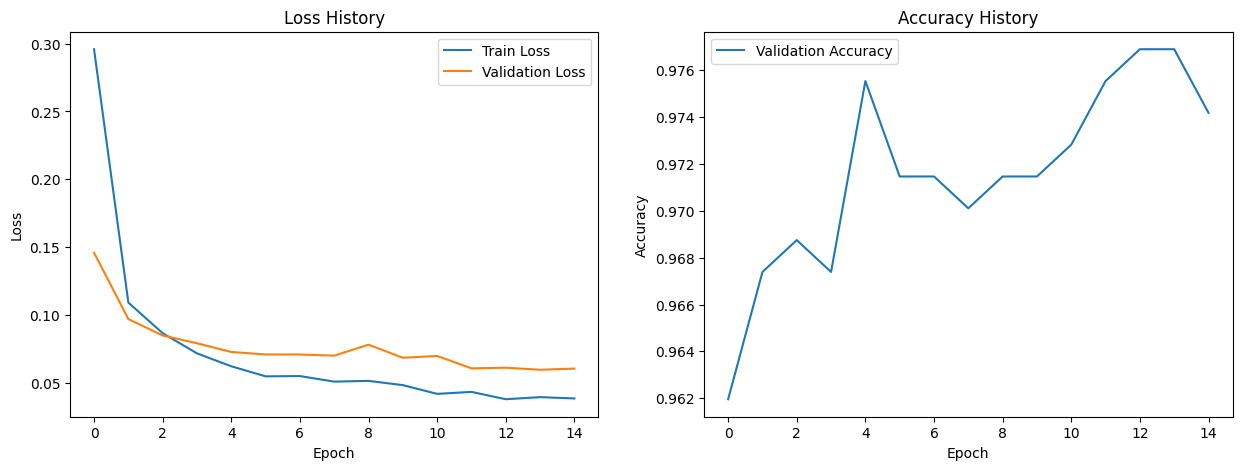

In [100]:
print("MobileNetV2 (TL, БЕЗ аугментацій)")
plot_training_history(history_no_aug)

In [87]:
summary(model_no_aug, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
MobileNetV2                                        [1, 2]                    --
├─Sequential: 1-1                                  [1, 1280, 7, 7]           --
│    └─Conv2dNormActivation: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                            [1, 32, 112, 112]         (864)
│    │    └─BatchNorm2d: 3-2                       [1, 32, 112, 112]         (64)
│    │    └─ReLU6: 3-3                             [1, 32, 112, 112]         --
│    └─InvertedResidual: 2-2                       [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4                        [1, 16, 112, 112]         (896)
│    └─InvertedResidual: 2-3                       [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5                        [1, 24, 56, 56]           (5,136)
│    └─InvertedResidual: 2-4                       [1, 24, 56, 56]           --
│    │    └─Sequential

In [88]:
latency_gpu_no_aug = measure_latency(model_no_aug, 'cuda')
latency_cpu_no_aug = measure_latency(model_no_aug, 'cpu')
print(f"MobileNetV2 (TL) WITHOUT Augmentations Latency | GPU: {latency_gpu_no_aug:.2f} ms | CPU: {latency_cpu_no_aug:.2f} ms")

MobileNetV2 (TL) WITHOUT Augmentations Latency | GPU: 5.01 ms | CPU: 28.33 ms


In [89]:
from PIL import Image

In [90]:
def predict_custom_image(image_path, model, class_names):
    transforms = val_transforms

    try:
        image = Image.open(image_path).convert('RGB')
    except FileNotFoundError:
        print(f"Помилка: Файл '{image_path}' не знайдено. Переконайтесь, що ви його завантажили.")
        return

    image_tensor = transforms(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        _, prediction = torch.max(outputs, 1)
        predicted_class = class_names[prediction.item()]

    plt.imshow(image)
    plt.title(f'Прогноз: {predicted_class}')
    plt.axis('off')
    plt.show()

Прогнози MobileNetV2 (TL)


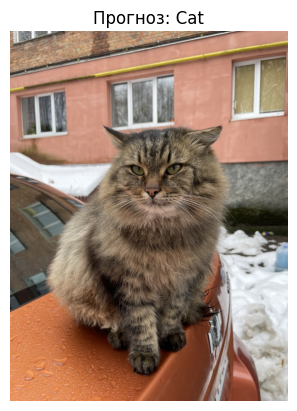

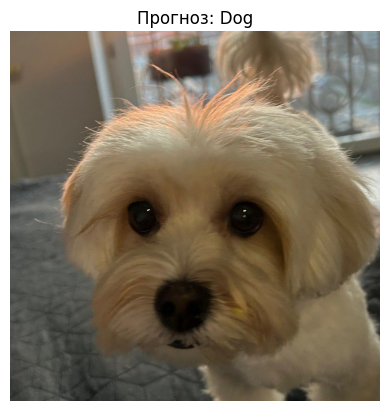

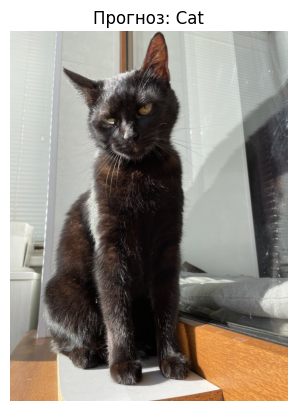

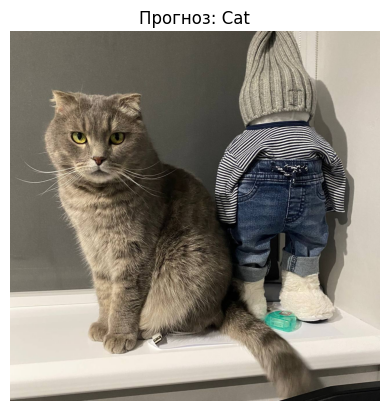

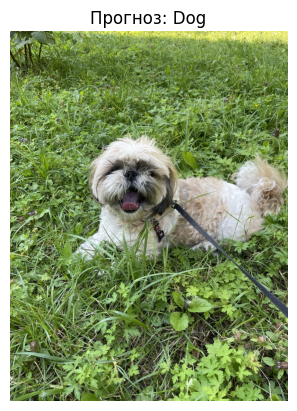

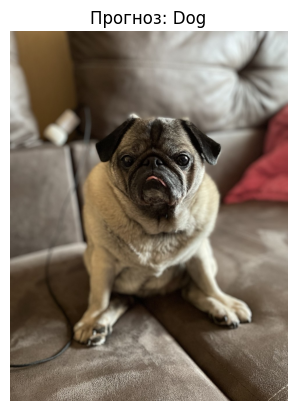

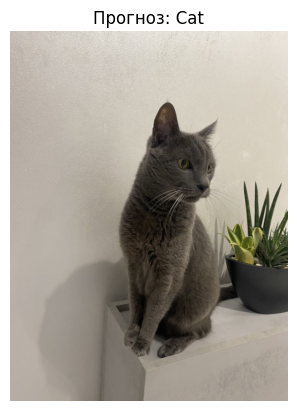

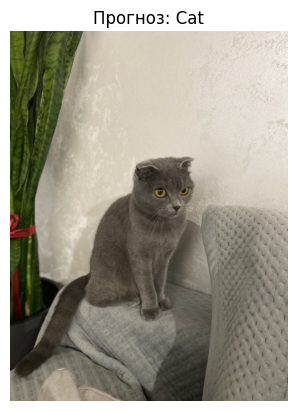


Прогнози EfficientNet-B0 (TL)


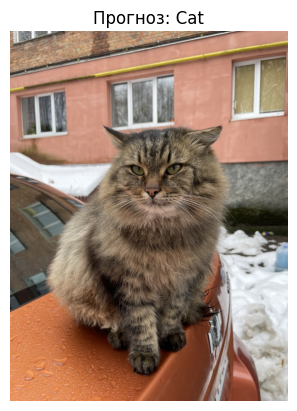

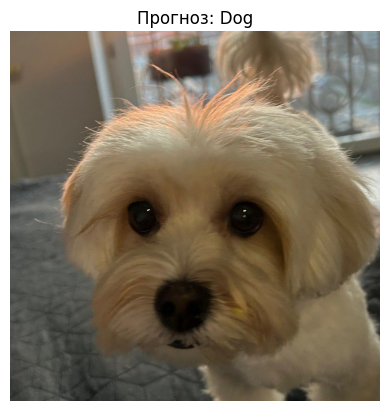

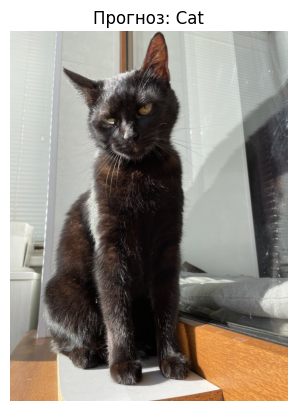

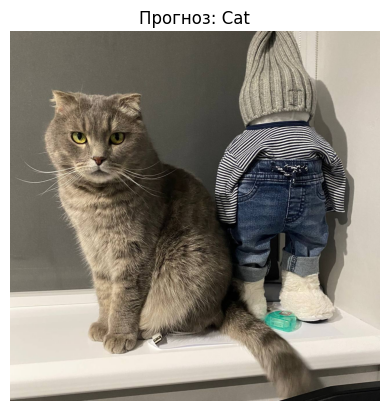

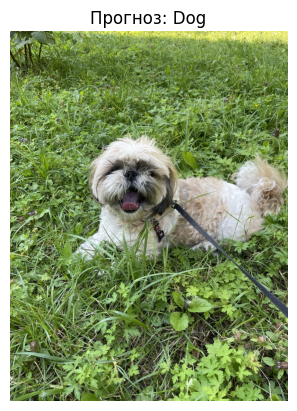

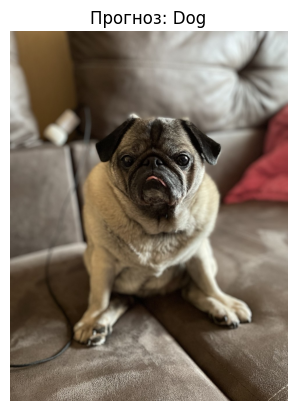

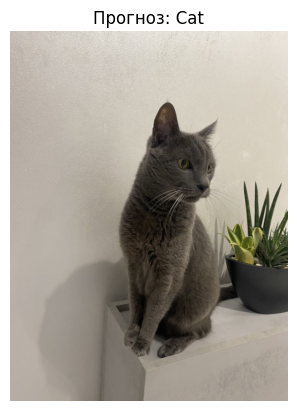

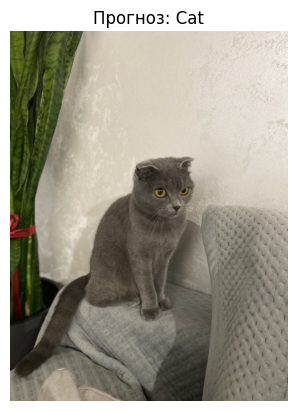

In [99]:
my_image_files = ['cat.jpg', 'dog.jpg', 'black_cat.jpg', 'dosha.jpg', 'shi_tsu.jpg', 'pug.jpg', 'zunia.jpg', 'busia.jpg']
class_names = ['Cat', 'Dog']

print("Прогнози MobileNetV2 (TL)")
model_mobilenet.to(device)
for img_path in my_image_files:
    predict_custom_image(img_path, model_mobilenet, class_names)

print("\nПрогнози EfficientNet-B0 (TL)")
model_effnet.to(device)
for img_path in my_image_files:
    predict_custom_image(img_path, model_effnet, class_names)

In [92]:
!pip install grad-cam -q

In [93]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

In [94]:
def visualize_grad_cam(model, target_layers, image_path, class_names):
    try:
        rgb_img = cv2.imread(image_path, 1)[:, :, ::-1] # Завантаження і конвертація BGR -> RGB
        rgb_img = cv2.resize(rgb_img, (224, 224))
        rgb_img = np.float32(rgb_img) / 255
    except Exception as e:
        print(f"Помилка завантаження зображення {image_path} для Grad-CAM: {e}")
        return

    # Створюємо тензор з val_transforms
    image = Image.open(image_path).convert('RGB')
    input_tensor = val_transforms(image).unsqueeze(0).to(device)

    model.requires_grad_(True)

    # Ініціалізація GradCAM
    cam = GradCAM(model=model, target_layers=target_layers)

    # Отримуємо прогноз моделі
    model.eval() # Переводимо в режим оцінки
    output = model(input_tensor)
    _, prediction = torch.max(output, 1)
    predicted_class_idx = prediction.item()

    targets = [ClassifierOutputTarget(predicted_class_idx)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(f"Grad-CAM: Прогноз = {class_names[predicted_class_idx]}")
    plt.axis('off')
    plt.show()

Grad-CAM для MobileNetV2


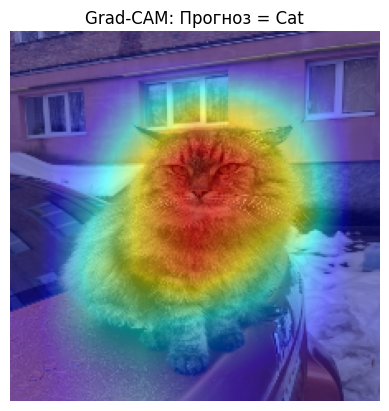


Grad-CAM для EfficientNet-B0


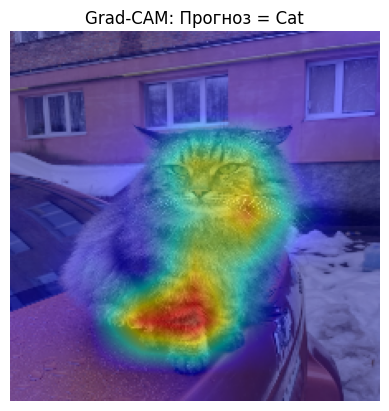

Grad-CAM для MobileNetV2


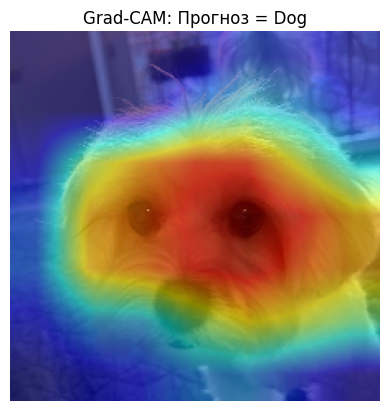


Grad-CAM для EfficientNet-B0


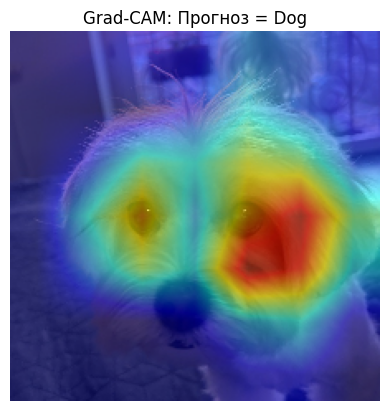

Grad-CAM для MobileNetV2


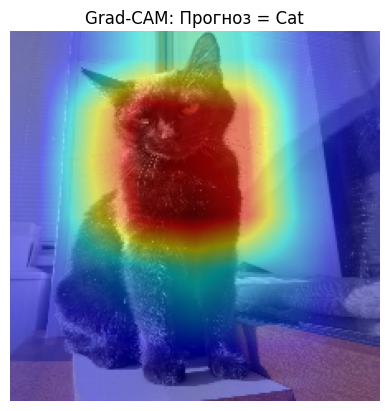


Grad-CAM для EfficientNet-B0


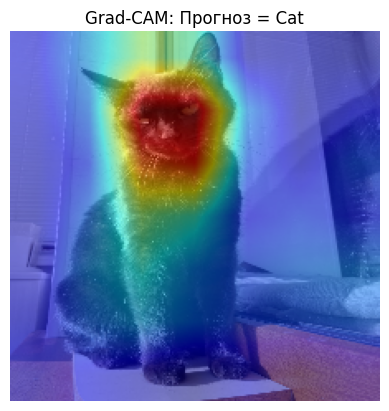

Grad-CAM для MobileNetV2


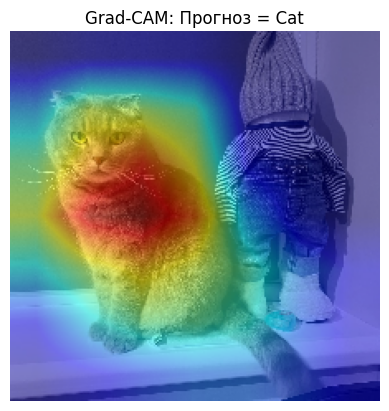


Grad-CAM для EfficientNet-B0


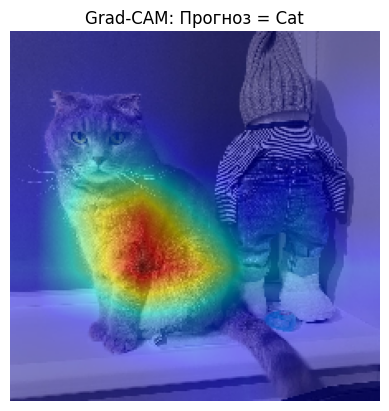

Grad-CAM для MobileNetV2


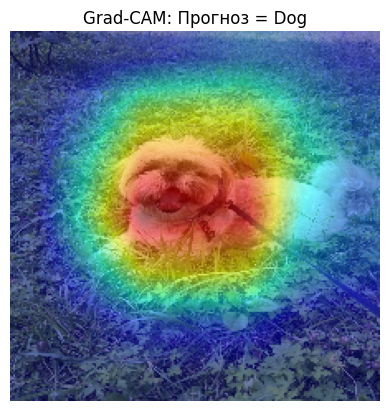


Grad-CAM для EfficientNet-B0


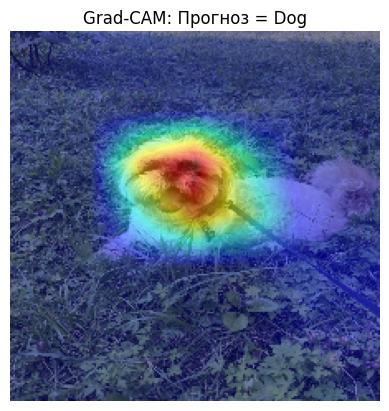

Grad-CAM для MobileNetV2


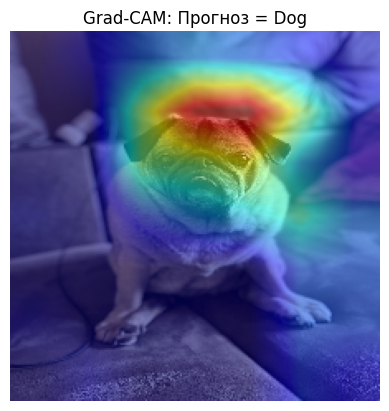


Grad-CAM для EfficientNet-B0


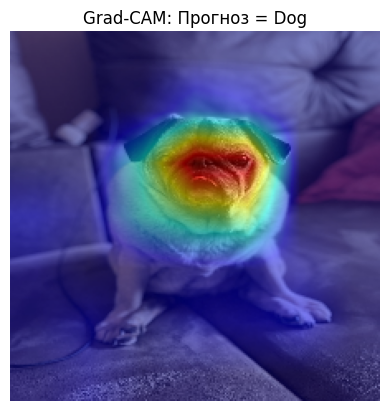

Grad-CAM для MobileNetV2


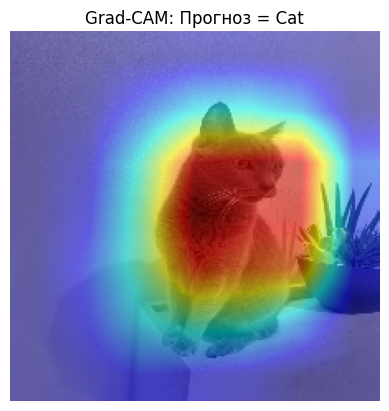


Grad-CAM для EfficientNet-B0


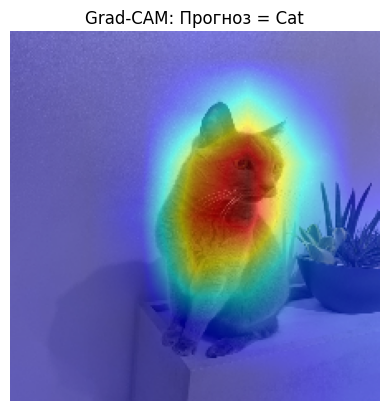

Grad-CAM для MobileNetV2


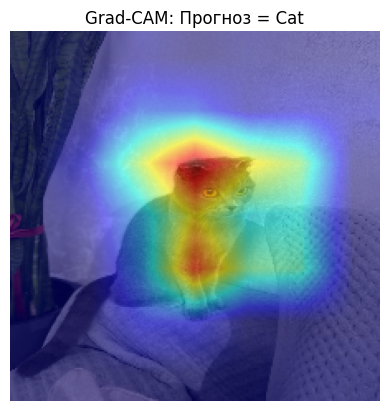


Grad-CAM для EfficientNet-B0


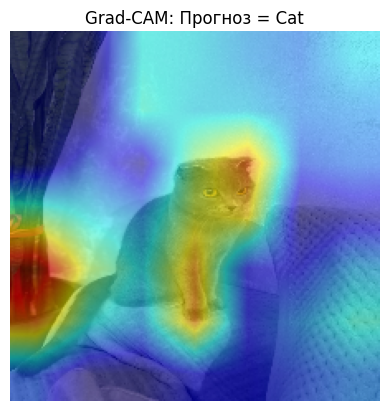

In [95]:
# Визначення цільових шарів
target_layers_mobilenet = [model_mobilenet.features[-1]]
target_layers_effnet = [model_effnet.features[-1]]

for image_path in my_image_files:

    # Grad-CAM для MobileNetV2
    print("Grad-CAM для MobileNetV2")
    visualize_grad_cam(model_mobilenet, target_layers_mobilenet, image_path, class_names)

    # Grad-CAM для EfficientNet-B0
    print("\nGrad-CAM для EfficientNet-B0")
    visualize_grad_cam(model_effnet, target_layers_effnet, image_path, class_names)

In [98]:
# MobileNetV2 (TL)
sum_mobilenet = summary(model_mobilenet, input_size=(1, 3, 224, 224), verbose=0)
params_mobilenet_m = sum_mobilenet.total_params / 1_000_000
flops_mobilenet_g = sum_mobilenet.total_mult_adds / 1_000_000_000

# MobileNetV2 (No Aug) - архітектура та ж, дані ті самі

# EfficientNet-B0 (TL)
sum_effnet = summary(model_effnet, input_size=(1, 3, 224, 224), verbose=0)
params_effnet_m = sum_effnet.total_params / 1_000_000
flops_effnet_g = sum_effnet.total_mult_adds / 1_000_000_000

# EfficientNet-B0 (Scratch)
sum_effnet_scratch = summary(model_effnet_scratch, input_size=(1, 3, 224, 224), verbose=0)
params_effnet_scratch_m = sum_effnet_scratch.total_params / 1_000_000
flops_effnet_scratch_g = sum_effnet_scratch.total_mult_adds / 1_000_000_000

# Створюємо списки для кожного стовпця
models = [
    'MobileNetV2 (TL, Aug)',
    'MobileNetV2 (TL, No Aug)',
    'EfficientNet-B0 (TL)',
    'EfficientNet-B0 (Scratch)'
]

params = [
    params_mobilenet_m,
    params_mobilenet_m,
    params_effnet_m,
    params_effnet_scratch_m
]

flops = [
    flops_mobilenet_g,
    flops_mobilenet_g,
    flops_effnet_g,
    flops_effnet_scratch_g
]

times = [
    np.mean(history_mobilenet.get('epoch_time', [np.nan])),
    np.mean(history_no_aug.get('epoch_time', [np.nan])),
    np.mean(history_effnet.get('epoch_time', [np.nan])),
    np.mean(history_effnet_scratch.get('epoch_time', [np.nan]))
]

latencies = [
    latency_gpu_mobilenet,
    latency_gpu_no_aug,
    latency_gpu_effnet,
    latency_gpu_effnet_scratch
]

accuracies = [
    max(history_mobilenet['val_acc']),
    max(history_no_aug['val_acc']),
    max(history_effnet['val_acc']),
    max(history_effnet_scratch['val_acc'])
]

f1_scores = [
    max(history_mobilenet['val_f1']),
    max(history_no_aug['val_f1']),
    max(history_effnet['val_f1']),
    max(history_effnet_scratch['val_f1'])
]

# Створення DataFrame
data_dict = {
    'Параметри (М)': params,
    'FLOPs (Г)': flops,
    'Час епохи (с)': times,
    'Latency 224px (мс, GPU)': latencies,
    'Acc': accuracies,
    'Macro-F1': f1_scores
}

# Створюємо DataFrame з 'models' як індексом
df_results = pd.DataFrame(data_dict, index=models)
df_results.index.name = 'Модель'

# Вивід та збереження

# Форматуємо для красивого виводу
pd.options.display.float_format = '{:,.4f}'.format
display(df_results)

# Збереження у CSV
df_results.to_csv('model_comparison_results_auto.csv')
print("\nDataFrame успішно збережено у 'model_comparison_results_auto.csv'")

Параметри (М)  FLOPs (Г)  Час епохи (с)  \
Модель                                                               
MobileNetV2 (TL, Aug)             2.2264     0.2995        19.0999   
MobileNetV2 (TL, No Aug)          2.2264     0.2995        13.6939   
EfficientNet-B0 (TL)              4.0101     0.3846        19.2467   
EfficientNet-B0 (Scratch)         4.0101     0.3846        21.1417   

                           Latency 224px (мс, GPU)    Acc  Macro-F1  
Модель                                                               
MobileNetV2 (TL, Aug)                      10.6017 0.9688    0.9632  
MobileNetV2 (TL, No Aug)                    5.0099 0.9769    0.9732  
EfficientNet-B0 (TL)                       19.8652 0.9674    0.9620  
EfficientNet-B0 (Scratch)                   8.8005 0.6834    0.6140


DataFrame успішно збережено у 'model_comparison_results_auto.csv'
